# TODO:

- Have fun

# Dependencies

In [1]:
import re
from typing import Literal, Any, Type, Sequence, Self
from itertools import combinations

import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFilter, ImageEnhance, ImageChops

# Utils

In [2]:
def snap(value: float, multiple: float) -> float:
    """Returns the `value` rounded to the nearest `multiple`"""
    
    return multiple * round(value / multiple)

def stick(value: float, options: set[float], loop: float = None) -> int:
    """Returns the closest `option` from the given `value`.  
    `loop=value` wraps the search at the given limit.
    """
    
    setoptions = set(options)
    if loop is not None:
        setoptions.add(loop)
        value %= loop
    vmin = min(setoptions, key=lambda x: abs(x - value))
    return vmin % loop

def clamp(value: float, minmax: tuple[float, float]) -> Any:
    """Forces the `value` to be in between `minmax` range."""
    
    if value < minmax[0]:
        return minmax[0]
    if value > minmax[1]:
        return minmax[1]
    return value

def coalesce(value: Any, structure: Type) -> Type:
    """Forces the `value` type into the given `structure`"""
    
    if isinstance(value, structure):
        return value
    
    if structure == list:
        return [value]
    
    if structure == set:
        return {value,}
    
    if structure == tuple:
        return (value,)
    
    return value

# https://stackoverflow.com/questions/2150108/efficient-way-to-rotate-a-list-in-python
def shift_list(_list: list, shift: int = 0, invert: bool = False) -> list:
    """`Shift`s the `list` values by their indexes.  
    `invert=True` first inverts the list order before shifting."""
    
    seq = _list.copy()
    
    if invert:
        seq = seq[::-1]
    
    if not shift:
        return seq
    
    for s in range(abs(shift)):
        if shift < 0:
            seq.append(seq.pop(0))
        
        if shift > 0:
            seq.insert(0, seq.pop(-1))
    
    return seq

def shift_string(text: str, shift: int = 0, invert: bool = False) -> list:
    """`Shift`s the `text` chars by their positions.  
    `invert=True` first inverts the string order before shifting."""
    
    if invert:
        text = text[::-1]
    
    if not shift:
        return text
    
    shift = (shift + len(text)) % len(text)
    stext = text[-shift:] + text[:-shift]
    
    return stext

def remap_list(_list: list, order: Sequence) -> list:
    """Remaps the `list` elements by the given `order` indexes.  
    
    >>> remap_list([1, 2, 3, 4], [0, 2, 1, 3])
    >>> [1, 3, 2, 4]
    """
    
    if len(_list) != len(order):
        return _list
    return [_list[pos] for pos in order]


def display_image(img: Image.Image, scale: float = 10) -> None:
    display(ImageOps.scale(img, scale, Image.Resampling.NEAREST))

# def match_closest_choice(value: str, choices: list[str]) -> list[str]:
#     best_score: int = 0
#     best_choice: str = None
#     print(f"{value=}")
#     for choice in choices:
#         matches = []
#         for idx in range(len(value)):
#             # Strong True find
#             # if value[idx] == choice[idx] and value[idx]:
#             #     matches.append(0)
#             # Strong equal find
#             if value[idx] == choice[idx]:
#                 matches.append(1)
#             # Weak wilcard find
#             elif choice[idx] == '.':
#                 matches.append(0.5)
#             # No find
#             else:
#                 matches.append(0)
            
#             score = sum(matches)
            
#             if score > best_score:
#                 best_score = score
#                 best_choice = choice
    
#     return best_choice

def match_choice(value: str, choices: list[str]) -> list[str]:
    # choices can be a list of precompiled patterns
    
    found = []
    
    for choice in choices:
        # pattern = choice.replace('x', '.')
        matcher = re.compile(f"^{choice}$")
        
        if matcher.match(value):
            found.append(choice)
    
    return found

def combine_choices(choice1: str, choice2: str) -> str:
    choice = []
    for c1, c2 in zip(choice1, choice2):
        if c1 == c2:
            choice.append(c1)
        
        elif c1 == '1' or c2 == '1':
            choice.append('1')
        
        else: # wildcards
            choice.append('.')
    
    return ''.join(choice)


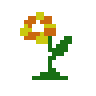

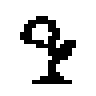

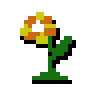

In [3]:
K2P = (
    (-1, -1), ( 0, -1), (+1, -1),
    (-1,  0),           (+1,  0),
    (-1, +1), ( 0, +1), (+1, +1),
)

def get_outline(
        image: Image.Image,
        color: str | tuple[int, int, int] = "black",
        thickness: float = 1.0,
        kernel: tuple[int, ...] = (0,0,0,0,0,0,0,0,),
    ) -> Image.Image:
    """
    thickness defaults to 1.0
    kernel defaults to (0,0,0,0,0,0,0,0)
    
    
    """
    
    ref_image = image.convert("RGBA")
    base_image = Image.new(ref_image.mode, ref_image.size, (0, 0, 0, 0))
    canvas = ImageDraw.Draw(base_image)
    
    # Ensures thickness is always at least 1
    T = clamp(thickness, (1, 1000))
    W, H = ref_image.size
    edge = ref_image.filter(ImageFilter.FIND_EDGES).load()
    
    for x in range(W):
        for y in range(H):
            for i, k in enumerate(kernel):
                if not k: continue
                
                # Kernel Offset XY
                kox, koy = K2P[i]
                try:
                    if edge[x+kox, y+koy][3]:
                        canvas.point((x, y), color)
                except IndexError:
                    pass
    
    return base_image

SCALE = 4

image = Image.open("addborder.png")
display_image(image, SCALE)

newimg = get_outline(image, kernel=(1,1,0,0,0,0,0,0))
display_image(newimg, SCALE)

refimage = image.convert("RGBA")
newimg.paste(refimage, mask=refimage)
display_image(newimg, SCALE)

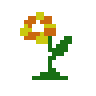

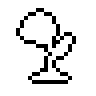

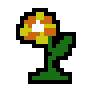

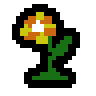

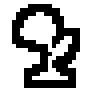

In [4]:
def get_outline(
        image: Image.Image,
        thickness: float = 1.0,
        color: str | tuple[int, int, int] = "black",
        combine: bool = True,
    ) -> Image.Image:
    
    ref_image = image.convert("RGBA")
    base_image = Image.new(ref_image.mode, ref_image.size, (0, 0, 0, 0))
    canvas = ImageDraw.Draw(base_image)
    
    # Ensures thickness is always at least 1
    T = clamp(thickness, (1, 1000))
    W, H = ref_image.size
    edge = ref_image.filter(ImageFilter.FIND_EDGES).load()
    
    for x in range(W):
        for y in range(H):
            if not edge[x,y][3]:
                continue
            
            if T % 1 == 0: # 1, 2, 3, ...round corners
                canvas.ellipse((x-T, y-T, x+T, y+T), fill=color)
            
            else: # 1.5, 2.5, 3.5, ... square corners
                canvas.rectangle((x-T+0.5, y-T+0.5, x+T-0.5, y+T-0.5), fill=color)
    
    if combine:
        base_image.paste(ref_image, mask=ref_image)
    
    else:
        alpha = ImageEnhance.Brightness(ref_image).enhance(256)
        base_image = ImageChops.subtract(base_image, alpha)
    
    return base_image

SCALE = 4

image = Image.open("addborder.png")
display_image(image, SCALE)

display_image(get_outline(image, 1, combine=False), SCALE)
display_image(get_outline(image, 1.5), SCALE)
display_image(get_outline(image, 2), SCALE)
display_image(get_outline(image, 2.5, combine=False), SCALE)

# Configs

In [5]:
Shapes = Literal['ort.square', 'ort.rect', 'iso', 'hex.flat', 'hex.point']

# Shape: 'ort.square', 'ort.rect', 'iso', 'hex.flat', 'hex.point'
# Operation: rotation(angle), mirror(axis)
# Value: angle or axis
TILE_MOVE_PARAMS: dict[Shapes, dict[str, dict[int|str, tuple[int, bool]]]] = {
    # ORTHOGONAL SQUARE/RECTANGLE ---------------------------------
    "ort": {
        # Rotation
        # | 0     | 90    | 180   | 270   |
        # | 1 2 3 | 3 4 5 | 5 6 7 | 7 8 1 |
        # | 8 0 4 | 2 0 6 | 4 0 8 | 6 0 2 |
        # | 7 6 5 | 1 8 7 | 3 2 1 | 5 4 3 |
        # Mirror
        # | 0     | '|'   | '-'   | '/'   | '\'   |
        # | 1 2 3 | 3 2 1 | 7 6 5 | 5 4 3 | 1 8 7 |
        # | 8 0 4 | 4 0 8 | 8 0 4 | 6 0 2 | 2 0 6 |
        # | 7 6 5 | 5 6 7 | 1 2 3 | 7 8 1 | 3 4 5 |
        "rotation": {
            0  : (+0, False),
            90 : (-2, False), # (3, 4, 5, 6, 7, 8, 1, 2)
            180: (-4, False), # (5, 6, 7, 8, 1, 2, 3, 4)
            270: (+2, False), # (7, 8, 1, 2, 3, 4, 5, 6)
        },
        "mirror": {
            '|' : (+3, True), # (3, 2, 1, 8, 7, 6, 5, 4)
            '-' : (-1, True), # (7, 6, 5, 4, 3, 2, 1, 8)
            '/' : (-3, True), # (5, 4, 3, 2, 1, 8, 7, 6)
            '\\': (+1, True), # (1, 8, 7, 6, 5, 4, 3, 2)
        },
    },
    
    # ISOMETRIC ---------------------------------------------------
    "iso": {
        # Rotation
        # | 0         | 90        | 180       | 270       |
        # |     1     |           |     5     |           |
        # |   8   2   |           |   4   6   |           |
        # | 7   0   3 |     X     | 3   0   7 |     X     |
        # |   6   4   |           |   2   8   |           |
        # |     5     |           |     1     |           |
        # Mirror
        # | 0         | '|'       | '-'       | '/'       | '\'       |
        # |     1     |     1     |     5     |           |           |
        # |   8   2   |   2   8   |   6   4   |           |           |
        # | 7   0   3 | 3   0   7 | 7   0   3 |     X     |     X     |
        # |   6   4   |   4   6   |   8   2   |           |           |
        # |     5     |     5     |     1     |           |           |
        "rotation": {
            180: (+4, False), # (5, 6, 7, 8, 1, 2, 3, 4)
        },
        "mirror": {
            '|': (+1, True), # (1, 8, 7, 6, 5, 4, 3, 2)
            '-': (-3, True), # (5, 4, 3, 2, 1, 8, 7, 6)
        },
    },
    
    # HEXAGONAL ---------------------------------------------------
    "hex.flat": {
        # FLAT
        # Rotation
        # | 0     | 90    | 180   | 270   |
        # |  1 2  |       |  4 5  |       |
        # | 6 0 3 |   X   | 3 0 6 |   X   |
        # |  5 4  |       |  2 1  |       |
        # Mirror
        # | 0     | '|'   | '-'   | '/'   | '\'   |
        # |  1 2  |  2 1  |  5 4  |       |       |
        # | 6 0 3 | 3 0 6 | 6 0 3 |   X   |   X   |
        # |  5 4  |  4 5  |  1 2  |       |       |
        "rotation": {
            180: (+3, False), # (4, 5, 6, 1, 2, 3)
        },
        "mirror": {
            '|': (+2, True), # (2, 1, 6, 5, 4, 3)
            '-': (-1, True), # (5, 4, 3, 2, 1, 6)
        },
    },
    
    "hex.point": {
        # POINT
        # Rotation
        # | 0     | 90    | 180   | 270   |
        # |   1   |       |   4   |       |
        # | 6 0 2 |   X   | 3 0 5 |   X   |
        # | 5   3 |       | 2   6 |       |
        # |   4   |       |   1   |       |
        # Mirror
        # | 0     | '|'   | '-'   | '/'   | '\'   |
        # |   1   |   1   |   4   |       |       |
        # | 6 0 2 | 2 0 6 | 5 0 3 |   X   |   X   |
        # | 5   3 | 3   4 | 6   2 |       |       |
        # |   4   |   4   |   1   |       |       |
        "rotation": {
            180: (+3, False), # (4, 5, 6, 1, 2, 3)
        },
        "mirror": {
            '|': (+1, True), # (1, 6, 5, 4, 3, 2)
            '-': (-2, True), # (4, 3, 2, 1, 6, 5)
        },
    },
}

def slice_tilemap(tilemap: tuple[tuple[int, ...], ...], x0: int, y0: int) -> tuple[int, ...]:
    r0 = tilemap[y0-1][x0-1:x0+2]
    r1 = tilemap[y0][x0-1:x0+2]
    r2 = tilemap[y0+1][x0-1:x0+2]
    r = r0+r1+r2
    return r

def slice_to_edges(*edges: int) -> str:
    edge = [*edges[:3], edges[5], *edges[6:][::-1], edges[3]]
    return ''.join(str(e) for e in edge)



# Classes

In [6]:
class Tile:
    """A framework to deal with Tiles"""
    
    # DUNDERS # ----------------------------------------------------------------
    def __init__(self,
            ref: str | Image.Image | np.typing.NDArray = None,
            shape: Shapes = None,
        ) -> None:
        """The base Tile class for tiling operations
        
        Returns:
            Tile: A PIL.Image wrapped around tiling methods
        """
        
        self.image: Image.Image
        
        if isinstance(ref, Image.Image):
            self.image = ref
        
        elif isinstance(ref, str):
            self.image = Image.open(ref)
        
        elif isinstance(ref, np.ndarray):
            self.image = Image.fromarray(ref)
        
        else:
            self.image = Image.new('RGB', (1, 1), (255, 0, 255))
        
        
        if shape is None:
            w, h = self.size
            shape = 'ort.square' if w == h else 'ort.rect'
        
        self.shape: str = shape
    
    def __repr__(self):
        try:
            display(self.image)
        
        finally:
            return f"size:{self.size} mode:{self.mode} shape:{self.shape}"
    
    # PROPERTIES # -------------------------------------------------------------
    @property
    def mode(self) -> str:
        return self.image.mode
    
    @property
    def size(self) -> tuple[int, int]:
        return self.image.size
    
    @property
    def center(self) -> tuple[float, float]:
        size = self.size
        return size[0]/2, size[1]/2
    
    @property
    def as_mask(self) -> Self:
        """Returns the Tile as a mask (only L channel).
        Useful to ensure a mask is indeed a mask.
        
        Returns:
            Tile: The converted Tile.
        """
        
        return Tile(self.image.convert('L'))
    
    @property
    def as_array(self) -> np.typing.NDArray:
        """Returns the Tile as a numpy array.
        Useful for matrix operations.
        
        Returns:
            np.ndarray: The numpy array.
        """
        
        return np.array(self.image)
    
    # METHODS # ----------------------------------------------------------------
    def copy(self) -> Self:
        return Tile(self.image.copy(), self.shape)
    
    def display(self,
            factor: float = 1.0,
            resample: Image.Resampling = Image.Resampling.NEAREST,
        ) -> None:
        
        display(ImageOps.scale(self.image, factor, resample))
    
    def invert(self) -> Self:
        """'invert' as in 'negative'"""
        
        image = ImageOps.invert(self.image)
        
        return Tile(image, self.shape)
    
    def rotate(self, angle: int, expand: bool = True) -> Self:
        image = self.image.rotate(int(angle), expand=expand)
        
        return Tile(image, self.shape)
    
    def mirror(self, axis: Literal['|', '-', '/', '\\']) -> Self:
        """Mirrors the Tile in the horizontal, vertical or diagonal directions.  
        
        Args:
            axis ('-', '|', '/', '\\'): Which axis to mirror the image.
        
        Returns:
            Tile: The mirrored Tile.
        """
        
        match axis:
            case '-':  image = ImageOps.flip(self.image)
            case '|':  image = ImageOps.mirror(self.image)
            case '\\': image = self.image.transpose(Image.Transpose.TRANSPOSE)
            case '/':  image = self.image.transpose(Image.Transpose.TRANSVERSE)
            case _:    image = self.image.copy()
        
        return Tile(image, self.shape)
    
    def scale(self,
            factor: float | tuple[float, float],
            resample: Image.Resampling = Image.Resampling.NEAREST,
        ) -> Self:
        """'scale' as in 'stretch by factor(x,y) or factor(x==y)'"""
        
        if isinstance(factor, (int, float)):
            image = ImageOps.scale(self.image, factor, resample)
        
        elif isinstance(factor, tuple):
            newsize = (
                int(self.size[0] * factor[0]),
                int(self.size[1] * factor[1]))
            image = self.image.resize(newsize, resample)
        
        else:
            print(f"Strange parameters")
            image = self.image.copy()
        
        return Tile(image, self.shape)
    
    def filter(self,
            filters: ImageFilter.Filter | list[ImageFilter.Filter],
            padding: int = 4,
        ) -> Self:
        
        w, h = self.size
        
        # Pads the image with itself to avoid filter bleeding
        image = self.take((w-padding, h-padding), (w+padding*2, h+padding*2)).image
        
        filters = coalesce(filters, list)
        for f in filters:
            image = image.filter(f)
        
        # Crops the extra border, restoring the original size
        image = ImageOps.crop(image, padding)
        
        return Tile(image, self.shape)
    
    def enhance(self, enhancer: ImageEnhance._Enhance, factor: float = 1.0) -> Self:
        image = enhancer(self.image).enhance(factor)
        
        return Tile(image, self.shape)
    
    def cutout(self, mask: Self) -> Self:
        """'cutout' as in 'cookie cutter'"""
        
        image = self.image.copy()
        image.putalpha(mask.as_mask.image)
        
        return Tile(image, mask.shape)
    
    def crop(self, box: tuple[int, int, int, int]) -> Self:
        image = self.image.crop(box)
        
        return Tile(image, self.shape)
    
    def take(self, pos: tuple[int, int], size: tuple[int, int]) -> Self:
        x0, y0 = pos
        width, height = size
        wrap_width, wrap_height = self.size
        
        xidx = (np.arange(x0, x0+width)  % wrap_width)
        yidx = (np.arange(y0, y0+height) % wrap_height)
        
        crop = self.as_array[np.ix_(yidx, xidx)]
        
        return Tile(crop)
    
    def offset(self, offset: tuple[int, int]) -> Self:
        width, height = self.size
        offx, offy = offset
        
        posx = (width + offx) % width
        posy = (height + offy) % height
        
        return self.take((posx, posy), self.size)
    
    def multiply(self, color_tile: Self) -> Self:
        image = ImageChops.multiply(self.image, color_tile.image)
        
        return Tile(image, self.shape)



class TileOps:
    # STATIC METHODS # ---------------------------------------------------------
    @staticmethod
    def create_symmetrical_outline(
            size: tuple[int, int],
            lines: list[tuple[tuple[float]]],
            **kwargs,
        ) -> Image.Image:
        
        image = Image.new("L", size, 0)
        draw  = ImageDraw.Draw(image)
        
        for line in lines:
            draw.line(line, fill=255)
        
        image.paste(ImageOps.flip(image), mask=ImageOps.invert(image))
        image.paste(ImageOps.mirror(image), mask=ImageOps.invert(image))
        
        return image
    
    @staticmethod
    def create_mask_from_outline(
            base: Image.Image,
            **kwargs,
        ) -> Image.Image:
        
        mask = base.copy()
        width, height = mask.size
        
        ImageDraw.floodfill(mask, (width / 2, height / 2), 255)
        
        return mask
    
    @staticmethod
    def overlay_tiles(base: Tile, head: Tile, mask: Tile = None, alpha: float = 0.5) -> Tile:
        """Merges two tiles into a new one.
        Must have a MASK or alpha value (default, 0.5).
        
        If using a MASK, it must have the same dimensions as both DATA Tiles.
        The pixel values from the MASK range from 0 (full base) to 255 (full head).
        
        The alpha value is used if no MASK is present.
        Its value is applied to the Tiles as a whole, not by pixel.
        
        Args:
            base (Tile): The Tile that goes on the bottom.
            head (Tile): The Tile that goes on top.
            mask (Tile, optional): A special Tile that controls how each pixel is merged. Defaults to None.
            alpha (float, optional): A value that controls how all pixels are merged. Defaults to 0.5.
        
        Returns:
            Tile: A new Tile resulting from the combination of both Tiles.
        """
        
        if mask is None:
            image = Image.blend(base.image, head.image, alpha)
            shape = base.shape
        
        else:
            image = Image.composite(head.image, base.image, mask.as_mask.image)
            shape = mask.shape
        
        return Tile(image, shape)
    
    @staticmethod
    def merge_tiles(*tiles: tuple[Tile, Tile]) -> Tile:
        """
        tiles = [(tile, mask), (tile, mask), ...]
        """
        REFTILE = tiles[0][0]
        REFMASK = tiles[-1][1]
        SIZE = REFTILE.size
        
        image = Image.new('RGBA', SIZE, (0, 0, 0, 0))
        
        for tile, mask in tiles:
            image.paste(tile.image, mask=mask.as_mask.image)
        
        return Tile(image, REFMASK.shape)
    
    @staticmethod
    def merge_masks(*masks: Tile) -> Tile:
        """Adds several MASKs together.
        Their values are combined with bitwise OR.
        
        Returns:
            Tile: A single Tile MASK
        """
        
        assert len(masks) >= 2, "Insufficient masks to be merged (<2)"
        
        base = masks[0].as_mask.as_array
        
        for mask in masks[1:]:
            base |= mask.as_mask.as_array
        
        return Tile(base, masks[-1].shape)
    
    @staticmethod
    def shade_tile(
            base: Tile,
            pattern_mask: Tile,
            offset: tuple[int, int],
            brightness: float = 1.0,
            ordered: bool = True,
        ) -> Tile:
        
        offset_mask = pattern_mask.offset(offset).invert()
        base_adjusted = base.enhance(ImageEnhance.Brightness, brightness)
        
        if ordered: # inverts which is overlaid on the other for double shades
            base, base_adjusted = base_adjusted, base
        base_shaded = TileOps.overlay_tiles(base, base_adjusted, offset_mask)
        
        return base_shaded



class TileGen:
    # MASK GENERATORS # --------------------------------------------------------
    @staticmethod
    def gen_ort_mask(size: int | tuple[int, int], **kwargs) -> Tile:
        """ Generates an orthogonal mask Tile given the size. """
        
        if isinstance(size, int):
            size = (size, size)
        
        mask_image = Image.new('L', size, 255)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_iso_mask(size: int | tuple[int, int], **kwargs) -> Tile:
        """Generates an isometric mask Tile given the size.
        """
        
        if isinstance(size, int):
            size = size//2
            W, H = size*2, size
        else:
            W, H = size
        
        lines = [
            ((0, H/2-1), (W/2-1, 0)), # top-left diagonal
        ]
        
        outline = TileOps.create_symmetrical_outline((W, H), lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        return Tile(mask_image, 'iso')
    
    @staticmethod
    def gen_hex_mask(
            size: int | tuple[int, int],
            top: Literal["flat", "point"] = "flat",
            grain: int = 4,
            **kwargs
        ) -> Tile:
        
        if isinstance(size, int):
            assert size % 2 == 0, "Size must be even numbered"
            
            SQRT3BY2 = 0.866
            size = size, int(snap(size*SQRT3BY2, grain)) # nearest multiple of grain
        
        
        # It's easier to always create as a flat top and rotate later
        width, height = size
        
        # Markers (Q.uarter, M.iddle)
        QW, MW = width/4, width/2
        QH, MH = height/4, height/2
        
        # Small correction for widths 8 and 12 (outliers)
        if width in (8, 12):
            QW += 0.5
        
        lines = [
            ((0.5, MH-0.5), (QW-0.5, 0.5)), # top-left diagonal
            ((QW+0.5, 0.5), (MW, 0.5)), # top line
        ]
        
        outline = TileOps.create_symmetrical_outline((width, height), lines, **kwargs)
        mask_image = TileOps.create_mask_from_outline(outline)
        
        if top == 'point':
            mask_image = mask_image.rotate(90, expand=True)
        
        return Tile(mask_image, f'hex.{top}')
    
    @staticmethod
    def gen_shape_mask(
            size: int | tuple[int, int],
            shape: Shapes,
            **params: dict[str, Any],
        ) -> Tile:
        
        if '.' in shape:
            shape, sdev = shape.split('.')
        
        match shape:
            case 'ort':
                return TileGen.gen_ort_mask(size, **params)
            
            case 'iso':
                return TileGen.gen_iso_mask(size, **params)
            
            case 'hex':
                return TileGen.gen_hex_mask(size, sdev, **params)
            
            case _:
                return Tile(None)
    
    # IMAGE GENERATORS # -------------------------------------------------------
    @staticmethod
    def gen_random_rgb(
            size: tuple[int, int],
            ranges: list[tuple[int, int]],
            mode: Literal['minmax', 'avgdev'] = 'minmax',
        ) -> Tile:
        """ Generates a random RGB Tile from the channels ranges. """
        
        size = size[1], size[0]
        
        if mode == 'minmax':
            image = (Image.fromarray(
                np.stack((
                    np.random.randint(ranges[0][0], ranges[0][1], size, dtype=np.uint8),
                    np.random.randint(ranges[1][0], ranges[1][1], size, dtype=np.uint8),
                    np.random.randint(ranges[2][0], ranges[2][1], size, dtype=np.uint8),
                ), axis=-1),
                'RGB')
            )
        
        elif mode == 'avgdev':
            image = (Image.fromarray(
                np.stack((
                    np.random.randint(ranges[0][0]-ranges[0][1], ranges[0][0]+ranges[0][1], size, dtype=np.uint8),
                    np.random.randint(ranges[1][0]-ranges[1][1], ranges[1][0]+ranges[1][1], size, dtype=np.uint8),
                    np.random.randint(ranges[2][0]-ranges[2][1], ranges[2][0]+ranges[2][1], size, dtype=np.uint8),
                ), axis=-1),
                'RGB')
            )
        
        return Tile(image)
    
    @staticmethod
    def gen_random_mask(
            size: tuple[int, int],
            vrange: tuple[int, int],
        ) -> Tile:
        """ Generates a random Mask Tile"""
        
        image = Image.fromarray(np.stack(
            np.random.randint(vrange[0], vrange[1], size, dtype=np.uint8), axis=-1), 'L')
        
        return Tile(image)
    
    @staticmethod
    def gen_texture_tile(
            size: int | tuple[int, int],
            texture_name: str,
            **kwargs,
        ) -> Tile:
        
        if isinstance(size, int):
            size = (size, size)
        
        FULL_SIZE = size
        HALF_SIZE = size[0]//2, size[1]//2
        HALF_WIDTH = size[0]//2, size[1]
        QUARTER_HEIGHT = size[0], size[1]//4
        
        tile: Tile = None
        
        match texture_name.lower():
            case 'grass':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((48, 64), (64, 108), (24, 32)))
                    .filter([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.9)
                )
            case 'grass.dry': # path
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((80, 8), (80, 8), (24, 4)), 'avgdev')
                    .filter([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.66)
                )
            case 'grass.wet': # moss
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((48, 4), (64, 4), (24, 4)), 'avgdev')
                    #.filter([ImageFilter.SMOOTH_MORE])
                )
            
            case 'water':
                tile = (TileGen
                    .gen_random_rgb(HALF_WIDTH, ((24, 32), (32, 48), (80, 120)))
                    .scale((2, 1))
                    .filter([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
                )
            case 'water.shallow': # puddle
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((64, 8), (72, 8), (120, 12)), 'avgdev')
                    .filter([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
                )
            
            case 'dirt':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((140, 160), (100, 120), (64, 80)))
                    .filter([ImageFilter.SMOOTH_MORE])
                )
            case 'dirt.wet': # mud
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((100, 6), (72, 6), (56, 4)), 'avgdev')
                    .filter([ImageFilter.SMOOTH])
                )
            
            case 'sand':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((240, 255), (200, 220), (180, 192)))
                    .filter([ImageFilter.SMOOTH])
                    # .enhance(ImageEnhance.Color, 0.2)
                )
            case 'clay':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((108, 120), (64, 80), (48, 64)))
                    .filter([ImageFilter.SMOOTH_MORE])
                )
            
            case 'stone':
                tile = (TileGen
                    .gen_random_rgb(HALF_SIZE, ((100, 112), (100, 112), (100, 112)))
                    .scale(2, Image.Resampling.NEAREST)
                    .enhance(ImageEnhance.Color, 0.2)
                )
            case 'gravel':
                tile = (TileGen
                    .gen_random_rgb(FULL_SIZE, ((96, 48), (96, 48), (96, 12)), 'avgdev')
                    .filter([ImageFilter.SMOOTH_MORE])
                    .enhance(ImageEnhance.Color, 0.05)
                )
            
            case 'wood':
                tile = (TileGen
                    .gen_random_rgb(QUARTER_HEIGHT, ((80, 8), (32, 6), (16, 4)), 'avgdev')
                    .scale((1, 4))
                    .filter([ImageFilter.BLUR])
                    .enhance(ImageEnhance.Contrast, 0.666)
                    .enhance(ImageEnhance.Color, 0.666)
                    .enhance(ImageEnhance.Brightness, 1.333)
                )
            
            # case '':
            #     return
            
            case _:
                tile = Tile()
        
        return tile
    
    @staticmethod
    def gen_brick_pattern_mask(
            size: tuple[int, int],
            brick_size: tuple[int, int],
            gap_width: int = 0,
            edge_width: int = 0,
            **params: dict[str, Any],
        ) -> Tile:
        """Works with:
        ```
        gap_width  | 1 | 2 | 3 | 4 | 5 | 6 | ...
        edge_width | * | * | * | X | * | ? | ...
        ```
        """
        
        MW, MH = size       # Mask Width and Height
        BW, BH = brick_size # Brick Width and Height
        BRW = MW + 2*BW     # Brick Row Width
        HBW = BW//2         # Half Brick Width
        BASE_VALUE = params.get('base_value', 0)
        FILL_VALUE = params.get('fill_value', 255)
        ROW_OFFSET = params.get('row_offset', HBW)
        INVERT     = params.get('invert', True)
        
        brick_template = Image.new('L', brick_size, BASE_VALUE)
        brick_temp_canv = ImageDraw.Draw(brick_template)
        brick_temp_canv.line(((0.5, 0.5), (BW+0.5, 0.5)), FILL_VALUE, gap_width)
        brick_temp_canv.line(((HBW+0.5, 0.5), (HBW+0.5, BH+0.5)), FILL_VALUE, gap_width)
        
        # Some fuckery, don't mess with it
        if edge_width:
            CO = gap_width / 2 if gap_width % 2 == 0 else 0.5 * gap_width
            polyconf = dict(n_sides=4, rotation=45, fill=FILL_VALUE)
            
            rad = edge_width + gap_width
            brick_temp_canv.regular_polygon((HBW+0.5, 0.5, rad), **polyconf)
            brick_temp_canv.regular_polygon((HBW+0.5, BH+CO, rad), **polyconf)
            
            if gap_width % 2 == 0:
                brick_temp_canv.regular_polygon((HBW+CO+0.5, 0.5, rad), **polyconf)
                brick_temp_canv.regular_polygon((HBW+CO+0.5, BH+CO+0.5, rad), **polyconf)
        
        # Builds the single brick row with the single brick template
        brick_row = Image.new('L', (BRW, BH), BASE_VALUE)
        for col in range(0, BRW, BW):
            brick_row.paste(brick_template, (col, 0))
        
        # Pastes the brick row template on each new row
        # The offset can be overriden with `row_offset=<int>`
        mask_image  = Image.new("L", size, BASE_VALUE)
        
        for cnt, row in enumerate(range(0, MH, BH)):
            offset = (cnt % 2) * ROW_OFFSET - (HBW + BW)
            
            mask_image.paste(brick_row, (offset, row))
        
        if INVERT:
            mask_image = ImageOps.invert(mask_image)
        
        return Tile(mask_image)
    
    @staticmethod
    def gen_line_draw_mask(
            size: tuple[int, int],
            lines: Sequence[tuple[float, float, float, float]],
            **params: dict[str, Any],
        ) -> Tile:
        """
        ```
        size = (10, 10)
        lines = [
            ((x0, y0), (x1, y1), width),
            ...
        ]
        ```
        """
        
        BASE_VALUE = params.get('base_value', 0)
        FILL_VALUE = params.get('fill_value', 255)
        INVERT = params.get('invert', True)
        
        mask_image = Image.new('L', size, BASE_VALUE)
        canvas = ImageDraw.Draw(mask_image)
        
        for line in lines:
            p0, p1, width = line
            canvas.line((p0, p1), FILL_VALUE, width)
        
        if INVERT:
            mask_image = ImageOps.invert(mask_image)
        
        return Tile(mask_image)


def combine_masks(
        mask_info: dict[str, Tile]
    ) -> tuple[str, Tile]:
    
    if not mask_info:
        return
    
    mask_data = mask_info.copy()
    base_edge, base_mask = mask_data.popitem()
    
    for edge, mask in mask_data.items():
        base_edge = combine_choices(base_edge, edge)
        base_mask = TileOps.merge_masks(base_mask, mask)
    
    return base_edge, base_mask


class TileSet(dict):
    pass

class MaskSet:
    def __init__(self, shape: Shapes, masks: dict[str, Tile] = None):
        self.shape: Shapes = shape
        self.masks: dict[str, Tile] = masks if masks is not None else {}
        self.finds: dict[str, int] = {
            'direct': 0,
            'regex': 0,
            'score': 0,
            'miss': 0,
        }
    
    def define(self, mask: Tile) -> str:
        pass
    
    def generate(self) -> Self:
        pass
    
    def __setitem__(self, key: str, item: Tile) -> None:
        self.masks[key] = item
    
    def __getitem__(self, key: str) -> Tile:
        if key in self.masks:
            self.finds['direct'] += 1
            return self.masks.get(key)
        
        choices = match_choice(key, self.masks.keys())
        if choices:
            choice = choices[0]
            self.finds['regex'] += 1
            return self.masks.get(choice)
        
        # choice = match_closest_choice(key, self.masks.keys())
        # if choice is not None:
        #     self.finds['score'] += 1
        #     return self.masks.get(choice)
        
        self.finds['miss'] += 1
        return Tile()
    
    def import_from(self, path: str) -> Self:
        pass
    
    def export_to(self, path: str, count: int, pad: int, **params) -> None:
        pass



class OrthogonalMasker(MaskSet):
    def __init__(self, masks = None):
        super().__init__('ort', masks)
    
    @staticmethod
    def generate(
            corner_NW: Tile = None,
            border_N: Tile = None,
            curve_NW: Tile = None,
            diagon_NW: Tile = None,
        ) -> MaskSet:
        """
        ```
        corner_NW | border_N | curve_NW | diagon_NW
        1 0 0     | 1 1 1    | . 1 .    | 1 1 0
        0 - 0     | 0 - 0    | 1 - 0    | 1 - 0
        0 0 0     | 0 0 0    | . 0 0    | 0 0 .
        ```
        """
        
        masks: dict[str, Tile] = {}
        
        # General Parameters
        ROT_PARAMS = TILE_MOVE_PARAMS['ort']['rotation']
        ANGLES = ROT_PARAMS.keys()
        
        SIMPLE_COMBOS: list[tuple[str, Tile, list[list[int]]]] = (
            ( # Generates all possible angle combinations for corners
                '10000000', corner_NW, [
                    item for s in range(1, 4+1)
                    for item in combinations(ANGLES, s)
                ]
            ),
            (
                '.1.00000', border_N, [
                    (0,), (90,), (180,), (270,),                # 4 sides
                    (0, 180), (90, 270),                        # channels
                ]
            ),
            (
                '1100.001', diagon_NW, [
                    (0,), (90,), (180,), (270,),                # 4 sides
                ]
            ),
            (
                '.1.000.1', curve_NW, [
                    (0,), (90,), (180,), (270,),                # 4 sides
                    (0, 90), (90, 180), (180, 270), (270, 0),   # dead ends
                    (0, 90, 180, 270,),                         # full circle
                ]
            ),
            
        )
        
        # Each mask piece is combined with itself in multiple ways
        for base_edge, base_tile, combos in SIMPLE_COMBOS:
            for combo in combos:
                temp_masks: dict[str, Tile] = {}
                for angle in combo:
                    edge = shift_string(base_edge, *ROT_PARAMS[angle])
                    mask = base_tile.rotate(angle)
                    temp_masks[edge] = mask
                
                full_edge, full_mask = combine_masks(temp_masks)
                masks[full_edge] = full_mask
        
        COMBINED_COMBOS: list[tuple[str, str]] = [
            ('10000000', '00.1.000'), # upper-left corner + right border
            ('00000010', '00.1.000'), # lower-left corner + right border
            ('10000010', '00.1.000'), # both left corners + right border
            ('10000000', '00.1.1.0'), # upper-left corner + lower-right curve
            ('00001000', '1100.001'), # lower-right corner + upper-right diagon
        ]
        
        # Mask pieces are combined and rotated to complete the masks
        for combo in COMBINED_COMBOS:
            edge_masks: dict[str, Tile] = {edge: masks[edge] for edge in combo}
            temp_edge, temp_mask = combine_masks(edge_masks)
            
            for angle in ANGLES:
                edge = shift_string(temp_edge, *ROT_PARAMS[angle])
                mask = temp_mask.rotate(angle)
                masks[edge] = mask
        
        return OrthogonalMasker(masks)
    
    def export_to(self,
            path: str,
            count: Literal[14, 15, 47] = 14,
            pad: int = 0,
            **params,
        ) -> None:
        
        base_size = self.masks['10000000'].size
        if count in (14, 15):
            size = (base_size[0]+pad)*4+pad, (base_size[1]+pad)*4+pad
        elif count == 47:
            size = (base_size[0]+pad)*12+pad, (base_size[1]+pad)*4+pad
        
        base_image = Image.new('L', size, 128)
        
        TILE_ORDERING: dict[int, dict[str, tuple[int, int]]] = {
            14: {
                '00000010': (0, 0), '00.1.000': (1, 0), '.000.111': (2, 0), '0000.1.0': (3, 0),
                '10001000': (0, 1), '00.111.0': (1, 1),                     '11.000.1': (3, 1),
                '00100000': (0, 2), '.1.00000': (1, 2), '.111.000': (2, 2), '.00000.1': (3, 2),
                                    '00001000': (1, 3), '00100010': (2, 3), '10000000': (3, 3),
            },
            15: {
                '1111.0.1': (0, 0), '11.000.1': (1, 0), '.1.00000': (2, 0), '.111.000': (3, 0),
                '.0.1.0.1': (0, 1), '.00000.1': (1, 1),                     '00.1.000': (3, 1),
                '.0.11111': (0, 2), '.000.111': (1, 2), '0000.1.0': (2, 2), '00.111.0': (3, 2),
                '11111111': (0, 3), '11.0.111': (1, 3), '.1.0.1.0': (2, 3), '.11111.0': (3, 3),
            }
        }
        
        for edge, pos in TILE_ORDERING.get(count).items():
            mask_image = self.masks[edge].as_mask.image
            ppos = (
                pos[0]*(base_size[0] + pad)+pad,
                pos[1]*(base_size[1] + pad)+pad)
            
            base_image.paste(mask_image, ppos)
        
        return base_image


TODO:
- Add tilemap parser
  - Wraparoud
  - Extend Borders

In [7]:
class TileMapData:
    def __init__(self, size: tuple[int, int], fill: int = 0, data: list[int] = None):
        self.size: tuple[int, int] = size
        if data is None:
            self.data: list[int] = [fill for x in range(size[0]*size[1])]
        else:
            self.data: list[int] = data
    
    def _conv_coords(self, point: tuple[int, int]) -> int:
        # Converts (X,Y) 2D coordinates to Y*W+X linear array coordinates
        X, Y = point
        W, H = self.size
        X, Y = X % W, Y % H
        return Y * W + X
    
    def __setitem__(self, key: tuple[int, int], item: int) -> None:
        self.data[self._conv_coords(key)] = item
        pass
    
    def __getitem__(self, key: tuple[int, int]) -> int:
        return self.data[self._conv_coords(key)]
    
    def __str__(self):
        W, H = self.size
        rows = [
            ' '*6 + ' '.join([f"{c:>3}" for c in range(W)]),
            '-'*(4*(W+1)+1),
        ]
        for row in range(H):
            first = row*W
            last = row*W + W
            rows.append(f"{row:>3} | " + ' '.join([f"{x:>3}" for x in self.data[first:last]]))
        return '\n'.join(rows)
    
    @staticmethod
    def from_csv(path: str, sep: str = ';') -> Self:
        import csv
        
        with open(path, newline='') as csvin:
            spamreader = csv.reader(csvin, delimiter=sep)#, quotechar='|')
            
            width, height = 0, 0
            data: list[int] = []
            
            for row in spamreader:
                width = len(row)
                height += 1
                data.extend(row)
        
        return TileMapData((width, height), data=data)
    
    def around(self,
            center: tuple[int, int],
            how: Literal["wrap", "extend"] = "wrap",
            reorder: bool = False,
        ) -> tuple[int, ...]:
        
        W, H = self.size
        CX, CY = center
        
        values: list[int] = []
        
        # Wrappeds or insiders
        if (0 < CX < W-1 and 0 < CY < H-1) or how == 'wrap':
            values = [
                self[CX-1, CY-1], self[CX  , CY-1], self[CX+1, CY-1],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX-1, CY+1], self[CX  , CY+1], self[CX+1, CY+1],
            ]
        
        # Corner NW
        elif center == (0, 0):
            values = [
                self[CX  , CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX  , CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX  , CY+1], self[CX  , CY+1], self[CX+1, CY+1],
            ]
        
        # Corner NE
        elif center == (W-1, 0):
            values = [
                self[CX-1, CY  ], self[CX  , CY  ], self[CX  , CY  ],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX  , CY  ],
                self[CX-1, CY+1], self[CX  , CY+1], self[CX  , CY+1],
            ]
        
        # Corner SE
        elif center == (W-1, H-1):
            values = [
                self[CX-1, CY-1], self[CX  , CY-1], self[CX  , CY-1],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX  , CY  ],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX  , CY  ],
            ]
        
        # Corner SW
        elif center == (0, H-1):
            values = [
                self[CX  , CY-1], self[CX  , CY-1], self[CX+1, CY-1],
                self[CX  , CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX  , CY  ], self[CX  , CY  ], self[CX+1, CY  ],
            ]
        
        # Side N
        elif CY == 0:
            values = [
                self[CX-1, CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX-1, CY+1], self[CX  , CY+1], self[CX+1, CY+1],
            ]
        
        # Side E
        elif CX == W-1:
            values = [
                self[CX-1, CY-1], self[CX  , CY-1], self[CX  , CY-1],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX  , CY  ],
                self[CX-1, CY+1], self[CX  , CY+1], self[CX  , CY+1],
            ]
        
        # Side S
        elif CY == H-1:
            values = [
                self[CX-1, CY-1], self[CX  , CY-1], self[CX+1, CY-1],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX-1, CY  ], self[CX  , CY  ], self[CX+1, CY  ],
            ]
        
        # Side W
        elif CX == 0:
            values = [
                self[CX  , CY-1], self[CX  , CY-1], self[CX+1, CY-1],
                self[CX  , CY  ], self[CX  , CY  ], self[CX+1, CY  ],
                self[CX  , CY+1], self[CX  , CY+1], self[CX+1, CY+1],
            ]
        
        if not reorder:
            return values
        
        return remap_list(values.copy(), [4, 0, 1, 2, 5, 8, 7, 6, 3])

tmd = TileMapData.from_csv("tmap.csv")
print(tmd)

        0   1   2   3   4   5   6
---------------------------------
  0 |   1   1   1   1   1   0   1
  1 |   1   0   0   0   1   0   0
  2 |   1   0   1   0   1   0   1
  3 |   1   0   0   0   1   0   0
  4 |   1   1   1   1   1   0   1


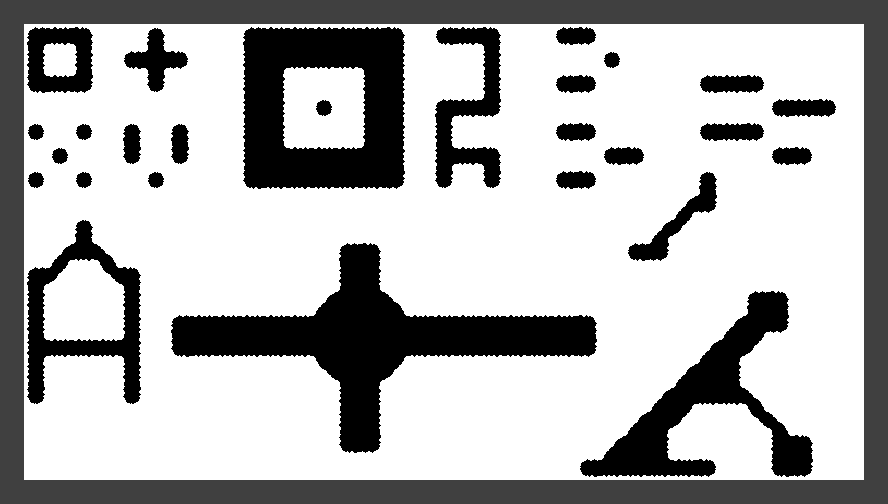

In [8]:
TEST_SET: tuple[tuple[int, ...], ...] = (
    (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1),
    (1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1),
    (1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1),
    (1,0,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1,1),
    (1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1),
    (1,0,1,0,1,0,1,0,1,1,0,0,1,1,1,0,0,1,0,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1,1),
    (1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1),
    (1,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1),
    (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1),
    (1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1),
    (1,1,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1),
    (1,0,0,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1),
    (1,0,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1),
    (1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1),
    (1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,1),
    (1,0,1,1,1,0,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1),
    (1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1),
    (1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,1,1,1,1),
    (1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,1),
    (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,1),
    (1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1),
)

tm = OrthogonalMasker.generate(
    Tile("./masks/corner_NW.png").as_mask,
    Tile("./masks/border_N.png").as_mask,
    Tile("./masks/curve_NW.png").as_mask,
    Tile("./masks/diagon_NW.png").as_mask,
)

# display_image(tm.export_to('./tileset.png', 14, 2), 4)
# display_image(tm.export_to('./tileset.png', 15, 2), 4)

head_tile = TileGen.gen_ort_mask(24)
base_tile = head_tile.copy().invert()

tiles: dict[tuple[int, int], Tile] = {}

tsize = 24
width, height = len(TEST_SET[0]), len(TEST_SET)

for x in range(1, width-1):
    for y in range(1, height-1):
        c = TEST_SET[y][x]
        if c == 1:
            tiles[(x, y)] = head_tile
            continue
        
        slc = slice_tilemap(TEST_SET, x, y)
        edg = slice_to_edges(*slc)
        if edg == '00000000':
            tiles[(x, y)] = base_tile
            continue
        
        tiles[(x, y)] = tm[edg]

base_image = Image.new('L', (tsize*width, tsize*height), 64)

for pos, tile in tiles.items():
    base_image.paste(tile.image, (pos[0]*tsize, pos[1]*tsize))

display_image(base_image, 1)

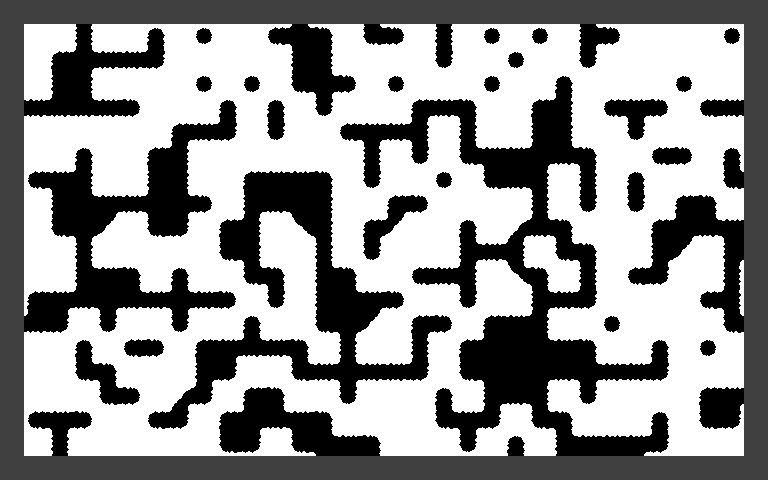

{'direct': 55, 'regex': 436, 'score': 0, 'miss': 0}


In [9]:
import random

def generate_random_bool_array(rows, cols):
    """
    Generates a 2D array of random booleans.

    Args:
        rows: The number of rows in the array.
        cols: The number of columns in the array.

    Returns:
        A list of lists representing the 2D array of random booleans.
    """
    return [[random.choice([1, 0]) for _ in range(cols)] for _ in range(rows)]

# Example usage:
cols = 32
rows = 20
random_bool_array = generate_random_bool_array(rows, cols)


head_tile = TileGen.gen_ort_mask(24)
base_tile = head_tile.copy().invert()

tiles: dict[tuple[int, int], Tile] = {}

tsize = 24

for x in range(1, cols-1):
    for y in range(1, rows-1):
        c = random_bool_array[y][x]
        if c == 1:
            tiles[(x, y)] = head_tile
            continue
        
        slc = slice_tilemap(random_bool_array, x, y)
        edg = slice_to_edges(*slc)
        if edg == '00000000':
            tiles[(x, y)] = base_tile
            continue
        
        tiles[(x, y)] = tm[edg]

base_image = Image.new('L', (tsize*cols, tsize*rows), 64)

for pos, tile in tiles.items():
    base_image.paste(tile.image, (pos[0]*tsize, pos[1]*tsize))

display_image(base_image, 1)
print(tm.finds)

10000000


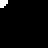

00000010


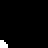

00001000


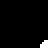

00100000


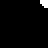

10000010


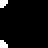

10001000


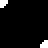

10100000


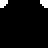

00001010


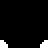

00100010


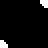

00101000


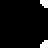

10001010


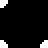

10100010


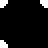

10101000


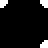

00101010


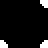

10101010


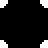

.1.00000


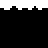

.00000.1


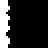

0000.1.0


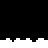

00.1.000


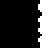

.1.0.1.0


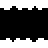

.0.1.0.1


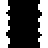

1100.001


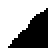

00.00111


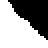

.0011100


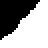

011100.0


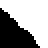

.1.000.1


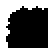

.000.1.1


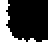

00.1.1.0


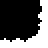

.1.1.000


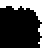

.1.0.1.1


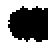

.0.1.1.1


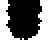

.1.1.1.0


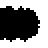

.1.1.0.1


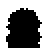

.1.1.1.1


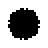

10.1.000


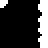

.1.00010


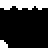

.00010.1


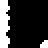

0010.1.0


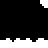

00.1.010


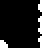

.1.01000


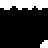

.01000.1


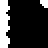

1000.1.0


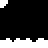

10.1.010


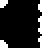

.1.01010


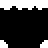

.01010.1


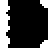

1010.1.0


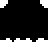

10.1.1.0


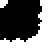

.1.1.010


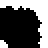

.1.010.1


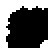

.010.1.1


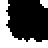

11001001


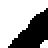

00100111


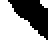

10011100


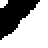

01110010


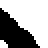

In [10]:
for edge, mask in tm.masks.items():
    print(edge)
    mask.display(2)

# Examples:

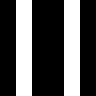

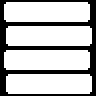

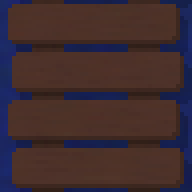

In [11]:
SCALE = 4
SIZE = (48, 48)
PLANK_SIZE = (SIZE[0]-2, SIZE[1]//4)
GAP_WIDTH = 3
EDGE_WIDTH = 1
SHADE_FORCE = 0.80

base_mask = TileGen.gen_ort_mask(SIZE)
head_mask1 = TileGen.gen_line_draw_mask(SIZE, [((SIZE[0]//4-0.5, 0), (SIZE[0]//4-0.5, SIZE[1]), 8), ((SIZE[0]-SIZE[0]//4-0.5, 0), (SIZE[0]-SIZE[0]//4-0.5, SIZE[1]), 8)], invert=False)
head_mask2 = TileGen.gen_brick_pattern_mask(SIZE, PLANK_SIZE, GAP_WIDTH, EDGE_WIDTH, row_offset=1).offset((0, 1))
head_mask1_2 = TileOps.merge_masks(head_mask1, head_mask2)

head_mask1.display(SCALE//2)
head_mask2.display(SCALE//2)

base_tile = TileOps.shade_tile(TileGen.gen_texture_tile(SIZE, 'water'), head_mask1_2, (-2, -3), SHADE_FORCE, True)
head_tile = TileGen.gen_texture_tile(SIZE, 'wood')
head_tile1 = TileOps.shade_tile(head_tile.enhance(ImageEnhance.Brightness, SHADE_FORCE), head_mask2, (1, 1), SHADE_FORCE, False)
head_tile2 = TileOps.shade_tile(head_tile.rotate(90), head_mask2, (1, 1), SHADE_FORCE, False)

TileOps.merge_tiles(
    (base_tile, base_mask),
    (head_tile1, head_mask1),
    (head_tile2, head_mask2),
).display(SCALE)

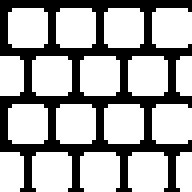

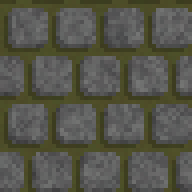

In [12]:
SCALE = 4
SIZE = 48
BRICK_SIZE = (SIZE//4, SIZE//4)
GAP_WIDTH = 2
EDGE_WIDTH = 1
SHADE_FORCE = 0.80

shape_mask = TileGen.gen_ort_mask(SIZE)
pattern_mask = TileGen.gen_brick_pattern_mask(shape_mask.size, BRICK_SIZE, GAP_WIDTH, EDGE_WIDTH)
pattern_mask.display(SCALE)

base_tile = TileGen.gen_texture_tile(shape_mask.size, 'grass.dry')
head_tile = TileGen.gen_texture_tile(shape_mask.size, 'gravel')

shaded_base = TileOps.shade_tile(base_tile, pattern_mask, (1, -1), SHADE_FORCE, True)
shaded_head = TileOps.shade_tile(head_tile, pattern_mask, (-1, 1), SHADE_FORCE, False)

combined = TileOps.overlay_tiles(shaded_base, shaded_head, pattern_mask)
combined.display(SCALE)

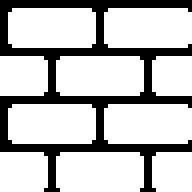

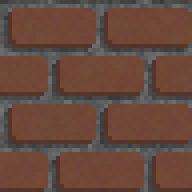

In [13]:
SCALE = 4
SIZE = 48
BRICK_SIZE = (SIZE//2, SIZE//4)
GAP_WIDTH = 2
EDGE_WIDTH = 1
SHADE_FORCE = 0.75

shape_mask = TileGen.gen_ort_mask(SIZE)
pattern_mask = TileGen.gen_brick_pattern_mask(shape_mask.size, BRICK_SIZE, GAP_WIDTH, EDGE_WIDTH)
pattern_mask.display(SCALE)

base_tile = TileGen.gen_texture_tile(shape_mask.size, 'gravel')
head_tile = TileGen.gen_texture_tile(shape_mask.size, 'clay')

shaded_base = TileOps.shade_tile(base_tile, pattern_mask, (1, -1), SHADE_FORCE, True)
shaded_head = TileOps.shade_tile(head_tile, pattern_mask, (-1, 1), SHADE_FORCE, False)

combined = TileOps.overlay_tiles(shaded_base, shaded_head, pattern_mask)
combined.display(SCALE)

Base texture


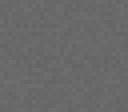

Head texture


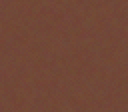

Brick pattern mask


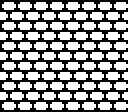

Overlay result


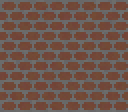

Hexagonal cut mask


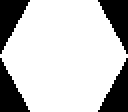

Final result


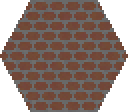

In [14]:
scale = 2
mask = TileGen.gen_hex_mask(64, 'flat')
pattern_mask = TileGen.gen_brick_pattern_mask(mask.size, (8, 5), 1, 1)
base = TileGen.gen_texture_tile(mask.size, 'stone')
head = TileGen.gen_texture_tile(mask.size, 'clay')
brick_mortar = TileOps.overlay_tiles(base, head, pattern_mask)
brick_mortar_tile = brick_mortar.copy().cutout(mask)


print("Base texture")
base.display(scale)

print("Head texture")
head.display(scale)

print("Brick pattern mask")
pattern_mask.display(scale)

print("Overlay result")
brick_mortar.display(scale)

print("Hexagonal cut mask")
mask.display(scale)

print("Final result")
brick_mortar_tile.display(scale)

Grass


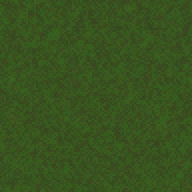

DryGrass


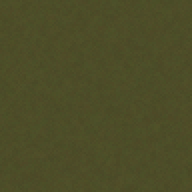

Moss


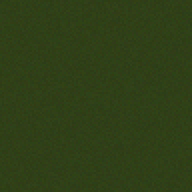

Water


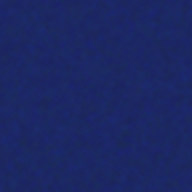

Dirt


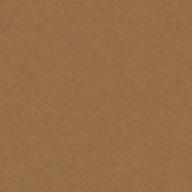

Mud


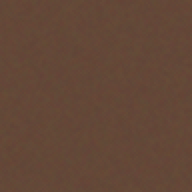

Sand


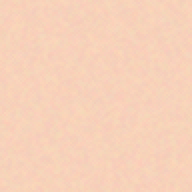

Clay


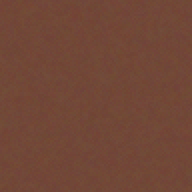

Stone


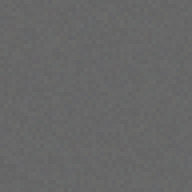

Gravel


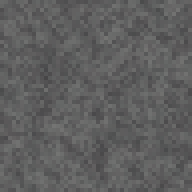

In [15]:
SCALE = 2

print("Grass")
(TileGen
    .gen_random_rgb((96, 96), ((48, 64), (64, 108), (24, 32)))
    .filter([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.9)
).display(SCALE)

print("DryGrass")
(TileGen
    .gen_random_rgb((96, 96), ((80, 8), (80, 8), (24, 4)), 'avgdev')
    .filter([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.66)
).display(SCALE)

print("Moss")
(TileGen
    .gen_random_rgb((96, 96), ((48, 4), (64, 4), (24, 4)), 'avgdev')
    #.filter([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Water")
(TileGen
    .gen_random_rgb((96, 96), ((24, 32), (32, 48), (80, 120)))
    .filter([ImageFilter.SMOOTH, ImageFilter.SMOOTH])
).display(SCALE)

print("Dirt")
(TileGen
    .gen_random_rgb((96, 96), ((140, 160), (100, 120), (64, 80)))
    .filter([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Mud")
(TileGen
    .gen_random_rgb((96, 96), ((100, 6), (72, 6), (56, 4)), 'avgdev')
    .filter([ImageFilter.SMOOTH])
).display(SCALE)

print("Sand")
(TileGen
    .gen_random_rgb((96, 96), ((240, 255), (200, 220), (180, 192)))
    .filter([ImageFilter.SMOOTH])
).display(SCALE)

print("Clay")
(TileGen
    .gen_random_rgb((96, 96), ((108, 120), (64, 80), (48, 64)))
    .filter([ImageFilter.SMOOTH_MORE])
).display(SCALE)

print("Stone")
(TileGen
    .gen_random_rgb((48, 48), ((100, 108), (100, 108), (100, 108)))
    .scale(2, Image.Resampling.NEAREST)
    .enhance(ImageEnhance.Color, 0.2)
).display(SCALE)

print("Gravel")
(TileGen
    .gen_random_rgb((48, 48), ((96, 48), (96, 48), (96, 12)), 'avgdev')
    .filter([ImageFilter.SMOOTH_MORE])
    .scale(2, Image.Resampling.NEAREST)
    .enhance(ImageEnhance.Color, 0.05)
).display(SCALE)


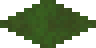

In [16]:
# TileGen.gen_hex_mask((24, 12), 'flat', 4).display(4)
# TileGen.gen_iso_mask(24).display(4)
(TileGen
    .gen_random_rgb((24, 12), ((48, 64), (64, 108), (24, 32)))
    .filter([ImageFilter.SMOOTH_MORE])
    .enhance(ImageEnhance.Color, 0.9)
    .cutout(TileGen.gen_iso_mask(24))
).display(4)

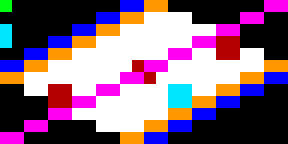

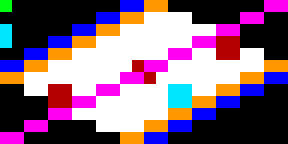

In [17]:
image = Tile('iso.png')#.image.convert('RGB')
image.display(12)
# display_image(image, 10)

image.rotate(180).mirror('-').mirror('|').display(12)

# W, H = image.size

# x1, y1 = 0, H
# x2, y2 = W, 0

# A = y2 - y1 
# B = -(x2 - x1)
# C = (-A * x1) - (B * y1)
# M = (A*A + B*B) ** 0.5

# A_ = A / M
# B_ = B / M
# C_ = C / M


# newimg = Image.new('RGB', image.size, (0, 0, 0))
# display_image(newimg, 10)

# def clamp(value: float, _range: tuple[float, float]) -> Any:
#     if value < _range[0]: return _range[0]
#     if value > _range[1]: return _range[1]
#     return value


# print(f"{W=} {H=}")

# for c in range(image.size[0]):
#     for r in range(image.size[1]):
#         p = image.getpixel((c, r))
        
#         D = A_*c + B_*r + C_
#         Px = int(clamp(c - 2*A_*D, (0, W-1)))
#         Py = int(clamp(r - 2*B_*D, (0, H-1)))
        
#         newimg.putpixel((Px, Py), p)

# display_image(newimg, 10)



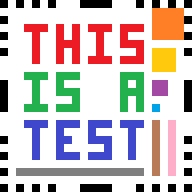

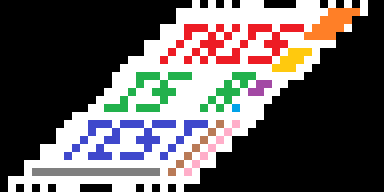

In [18]:
from PIL import Image, ImageTransform

image = Image.open("test.png")
display_image(image, 8)



# Define the shear factor (e.g., 0.5 for moderate shear)
shear_x = 1.0  # x-shear
shear_y = 0.0  # no y-shear

# Construct the 6-tuple affine matrix for shearing
# Affine matrix is (a, b, c, d, e, f)
# For shear in x-direction: b = shear_x
# Transformation matrix:
# | a  b  c |
# | d  e  f |
# | 0  0  1 |

# sx=-1 -> image.size[0] + (image.size[0] * shear_x)
# sx=1  -> -(image.size[0] * shear_x)
matrix = (
    1,       shear_x, -(image.size[0] * shear_x),
    shear_y,       1, 0,
    0,             0, 1,
) 

# Create AffineTransform object
transform = ImageTransform.AffineTransform(matrix)

resize = (
    int(image.size[0] * (1 + abs(shear_x))),
    int(image.size[1] * (1 + abs(shear_y))),
)

sheared_image = image.transform(resize, transform, resample=Image.Resampling.NEAREST)

display_image(sheared_image, 8)